In [180]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model, svm
import statsmodels.api as sm
import numpy as np
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.under_sampling import NearMiss

In [181]:
%matplotlib inline

In [182]:
df = pd.read_csv("SDSS-DR14.csv")
df

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.237650e+18,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,301,3,161,5.033450e+17,GALAXY,0.027583,447,51877,246
9996,1.237650e+18,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,301,3,162,5.033400e+17,GALAXY,0.117772,447,51877,228
9997,1.237650e+18,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,301,3,162,8.222620e+18,STAR,-0.000402,7303,57013,622
9998,1.237650e+18,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,301,3,163,5.033400e+17,GALAXY,0.014019,447,51877,229


## Data Description
- Position Data
    - objid: Object ID
    - ra: Right Ascension
    - dec: Declination

- Wavelength magnitude {u,g,r,i,z}
    - u: Ultraviolet
    - g: Green
    - r: Red
    - i: Infrared - 7600 Â
    - z: Infrared - 9100 Â

- Optical obs {redshift,plate,mjd,fiberid}
    - redshift: Wavelenght displacement
    - plate: SDSS plug plate used
    - mjd: Modified Julian Date
    - fiberid: Fiber number

Following data will not be used because they do not describe object characteristics

- objid
- ra
- dec
- run
- rerun
- camcol
- field
- specobjid
- plate
- mjd
- fiberid

In [183]:
#Drop unused columns
df.drop(columns = ['objid','ra','dec','run','rerun','camcol','field','specobjid','plate','mjd','fiberid'], inplace=True)

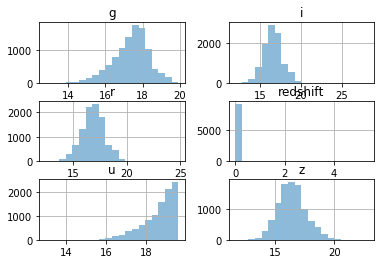

In [184]:
ax = df.hist(bins = 20, alpha = 0.5)

In [185]:
Y = df['class']

In [186]:
X = df.drop(columns = ['class'])

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .3, random_state=45)

In [188]:
print('Total train samples by class \n', y_train.value_counts())
print('Ratios: \n', y_train.value_counts()/y_train.value_counts().min())

Total train samples by class 
 GALAXY    3481
STAR      2902
QSO        617
Name: class, dtype: int64
Ratios: 
 GALAXY    5.641815
STAR      4.703404
QSO       1.000000
Name: class, dtype: float64


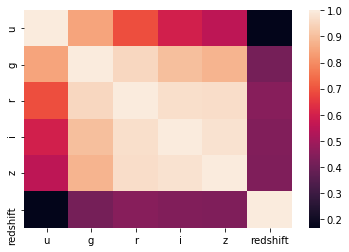

In [189]:
sb.heatmap(X_train.corr())
plt.show()

### Es necesario balancear el dataset de entrenamiento
Ante la posibilidad de que el modelo sea sobreentrenado se usara <i>Undersampling</i> como balanceador

In [190]:
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=5)
# transform the dataset
undersampled_trainX, undersampled_trainY = undersample.fit_resample(X_train, y_train)
undersampled_train = pd.concat([pd.DataFrame(undersampled_trainY), pd.DataFrame(undersampled_trainX)], axis=1)

In [191]:
undersampled_train.groupby('class').count()

,u,g,r,i,z,redshift
class,,,,,,
GALAXY,617,617,617,617,617,617
QSO,617,617,617,617,617,617
STAR,617,617,617,617,617,617


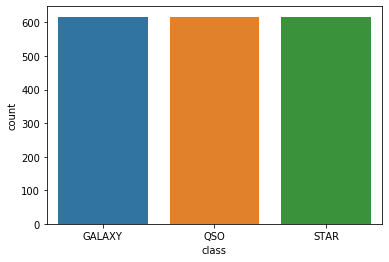

In [192]:
sb.countplot(x = 'class', data = undersampled_train)
plt.show()

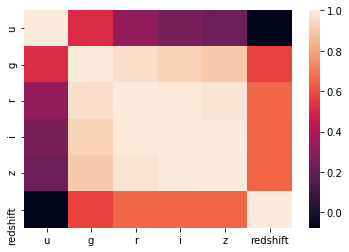

In [193]:
sb.heatmap(undersampled_trainX.corr())
plt.show()

# Logistic Regression

In [194]:
#Aprendizaje
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(undersampled_trainX, undersampled_trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [195]:
#Predicciones
y_pred = LogReg.predict(X_test)

In [196]:
#Evaluación del rendimiento del clasificador
logreg_matrix = confusion_matrix(y_test, y_pred)

In [197]:
logreg_report = classification_report(y_test, y_pred)

# Decision tree

In [198]:
from sklearn import tree
#Entrenamiento
dtree = tree.DecisionTreeClassifier()
dtree.fit(undersampled_trainX,undersampled_trainY)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [199]:
#Predicciones
y_pred = clf.predict(X_test)
#Evaluación del rendimiento del clasificador
#from sklearn.metrics import confusion_matrix
tree_matrix = confusion_matrix(y_test, y_pred)
#Print de la matriz de confusión
tree_report = classification_report(y_test, y_pred)

# Random Forest

In [200]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=15)
#Profiling
forest.fit(undersampled_trainX,undersampled_trainY) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [201]:
#Predicciones
y_pred = rng_fst.predict(X_test)
#Evaluación del rendimiento del clasificador
forest_matrix = confusion_matrix(y_test, y_pred)
#Print de la matriz de confusión
forest_report = classification_report(y_test, y_pred)

In [202]:
print("Logistic Regression Report: \n" + logreg_report)
print("Desicion Tree Report: \n" + tree_report)
print("Random Forest Report: \n" + forest_report)

Logistic Regression Report: 
              precision    recall  f1-score   support

      GALAXY       0.97      0.82      0.89      1517
         QSO       0.97      0.96      0.96       233
        STAR       0.82      0.97      0.89      1250

    accuracy                           0.89      3000
   macro avg       0.92      0.92      0.91      3000
weighted avg       0.90      0.89      0.89      3000

Desicion Tree Report: 
              precision    recall  f1-score   support

      GALAXY       1.00      0.94      0.97      1517
         QSO       0.75      0.98      0.85       233
        STAR       0.99      1.00      0.99      1250

    accuracy                           0.97      3000
   macro avg       0.91      0.97      0.94      3000
weighted avg       0.97      0.97      0.97      3000

Random Forest Report: 
              precision    recall  f1-score   support

      GALAXY       1.00      0.83      0.91      1517
         QSO       0.50      0.98      0.66       233
